In [1]:
!pip install sklearn-pandas==1.5.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn_pandas import CategoricalImputer

Load the insurance fraud dataset

In [3]:
data = pd.read_csv('./insuranceFraud.csv')

In [4]:
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [5]:
data.info

<bound method DataFrame.info of      months_as_customer  age  policy_number policy_bind_date policy_state  \
0                   328   48         521585       10/17/2014           OH   
1                   228   42         342868        6/27/2006           IN   
2                   134   29         687698         9/6/2000           OH   
3                   256   41         227811        5/25/1990           IL   
4                   228   44         367455         6/6/2014           IL   
..                  ...  ...            ...              ...          ...   
995                   3   38         941851        7/16/1991           OH   
996                 285   41         186934         1/5/2014           IL   
997                 130   34         918516        2/17/2003           OH   
998                 458   62         533940       11/18/2011           IL   
999                 456   60         556080       11/11/1996           OH   

    policy_csl  policy_deductable  policy_a

Data Preprocessing: Replace '?' with NaN

In [6]:
data = data.replace('?', np.nan)

Drop unnecessary columns

In [7]:
cols_to_drop = ['policy_number', 'policy_bind_date', 'policy_state', 'insured_zip', 'incident_location',
                'incident_date', 'incident_state', 'incident_city', 'insured_hobbies', 'auto_make',
                'auto_model', 'auto_year']
data.drop(columns=cols_to_drop, inplace=True)

In [8]:
data.sample(5)

,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_relationship,...,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported
34,149,37,500/1000,500,1415.68,0,MALE,PhD,prof-specialty,own-child,...,1,YES,0,1,YES,64800,10800,5400,48600,N
157,428,59,250/500,500,1344.36,7000000,FEMALE,JD,prof-specialty,other-relative,...,1,NaN,2,3,NO,6500,1300,650,4550,N
94,271,42,100/300,500,1515.30,0,FEMALE,High School,machine-op-inspct,not-in-family,...,3,NO,1,0,NO,93720,17040,8520,68160,N
734,246,43,250/500,1000,1267.40,6000000,MALE,JD,adm-clerical,husband,...,1,NO,2,1,NaN,50700,5070,5070,40560,N
10,235,42,100/300,500,1253.12,4000000,FEMALE,Masters,exec-managerial,other-relative,...,1,YES,2,2,NaN,87010,7910,15820,63280,N


Check for missing values

In [9]:
missing_values = data.isna().sum()
missing_values

months_as_customer               0
age                              0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_relationship             0
capital-gains                    0
capital-loss                     0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted            0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries                  0
witnesses                        0
police_report_available        343
total_claim_amount               0
injury_claim                     0
property_claim                   0
vehicle_claim                    0
fraud_reported                   0
dtype: int64

Data Imputation: Replace missing values in categorical columns

Importing the categorical imputer

In [10]:
imputer = CategoricalImputer()

In [11]:
data['collision_type'] = imputer.fit_transform(data['collision_type'])
data['property_damage'] = imputer.fit_transform(data['property_damage'])
data['police_report_available'] = imputer.fit_transform(data['police_report_available'])

In [12]:
cat_df = data.select_dtypes(include=['object']).copy()

In [13]:
cat_df.columns

Index(['policy_csl', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_relationship', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'property_damage', 'police_report_available', 'fraud_reported'],
      dtype='object')

Custom Mapping for Encoding

In [14]:
cat_df['policy_csl'] = cat_df['policy_csl'].map({'100/300': 1, '250/500': 2.5, '500/1000': 5})
cat_df['insured_education_level'] = cat_df['insured_education_level'].map(
    {'JD': 1, 'High School': 2, 'College': 3, 'Masters': 4, 'Associate': 5, 'MD': 6, 'PhD': 7})
cat_df['incident_severity'] = cat_df['incident_severity'].map(
    {'Trivial Damage': 1, 'Minor Damage': 2, 'Major Damage': 3, 'Total Loss': 4})
cat_df['insured_sex'] = cat_df['insured_sex'].map({'FEMALE': 0, 'MALE': 1})
cat_df['property_damage'] = cat_df['property_damage'].map({'NO': 0, 'YES': 1})
cat_df['police_report_available'] = cat_df['police_report_available'].map({'NO': 0, 'YES': 1})
cat_df['fraud_reported'] = cat_df['fraud_reported'].map({'N': 0, 'Y': 1})

Encoding categorical variables

In [15]:
for col in cat_df.drop(columns=['policy_csl','insured_education_level','incident_severity','insured_sex','property_damage','police_report_available','fraud_reported']).columns:
    cat_df= pd.get_dummies(cat_df, columns=[col], prefix = [col], drop_first=True)

In [16]:
cat_df.sample(5)

,policy_csl,insured_sex,insured_education_level,incident_severity,property_damage,police_report_available,fraud_reported,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,...,insured_relationship_wife,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Rear Collision,collision_type_Side Collision,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
310,1.0,0,7,3,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
787,5.0,1,3,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
386,2.5,0,3,3,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
297,1.0,0,3,1,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,1
979,5.0,0,4,4,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [17]:
num_df = data.select_dtypes(include=['int64']).copy()

In [18]:
num_df.head()

,months_as_customer,age,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim
0,328,48,1000,0,53300,0,5,1,1,2,71610,6510,13020,52080
1,228,42,2000,5000000,0,0,8,1,0,0,5070,780,780,3510
2,134,29,2000,5000000,35100,0,7,3,2,3,34650,7700,3850,23100
3,256,41,2000,6000000,48900,-62400,5,1,1,2,63400,6340,6340,50720
4,228,44,1000,6000000,66000,-46000,20,1,0,1,6500,1300,650,4550


In [19]:
encoded_data=pd.concat([num_df,cat_df], axis=1)

In [20]:
encoded_data.sample(5)

,months_as_customer,age,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,...,insured_relationship_wife,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Rear Collision,collision_type_Side Collision,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
618,97,28,1000,0,0,-32600,22,1,1,0,...,0,0,1,0,1,0,0,0,0,0
836,257,43,1000,0,52100,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
325,399,55,2000,0,0,-65400,23,3,1,1,...,0,0,0,0,0,1,0,0,0,1
235,428,54,2000,0,0,-24400,16,3,1,0,...,0,0,0,0,0,1,1,0,0,0
769,169,37,1000,0,70600,-48500,4,3,2,1,...,0,0,0,0,0,1,0,0,0,1


Data Visualization and Analysis (Continued)

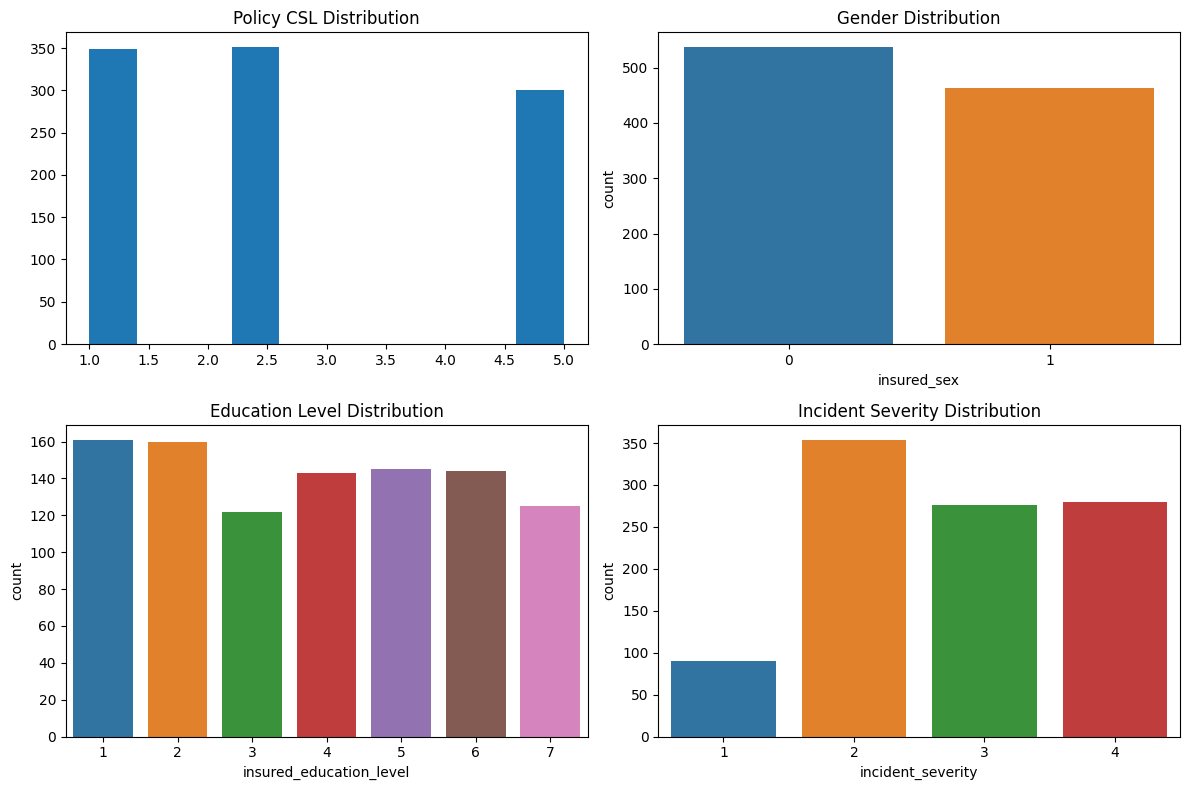

In [22]:
plt.figure(figsize=(12, 8))
# Distribution of Policy CSL
plt.subplot(2, 2, 1)
plt.hist(encoded_data['policy_csl'])
plt.title('Policy CSL Distribution')
# Gender Distribution
plt.subplot(2, 2, 2)
sns.countplot(x='insured_sex', data=encoded_data)
plt.title('Gender Distribution')
# Education Level Distribution
plt.subplot(2, 2, 3)
sns.countplot(x='insured_education_level', data=encoded_data)
plt.title('Education Level Distribution')
# Incident Severity Distribution
plt.subplot(2, 2, 4)
sns.countplot(x='incident_severity', data=encoded_data)
plt.title('Incident Severity Distribution')

plt.tight_layout()
plt.show()

Analysis: Based on the plots, we can observe the following:<br>
- Most policies have a CSL of 100/300.<br>
- Gender distribution is roughly balanced.<br>
- Education level distribution shows that the majority of insured have "High School" education.<br>
- Most incidents result in "Minor Damage," while "Trivial Damage" incidents are the least frequent.

<Axes: xlabel='months_as_customer', ylabel='age'>

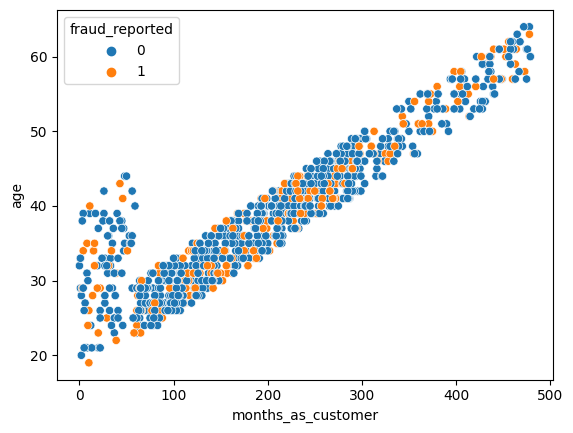

In [23]:
sns.scatterplot(x=encoded_data['months_as_customer'],y=encoded_data['age'], hue=encoded_data['fraud_reported'] )

<Axes: >

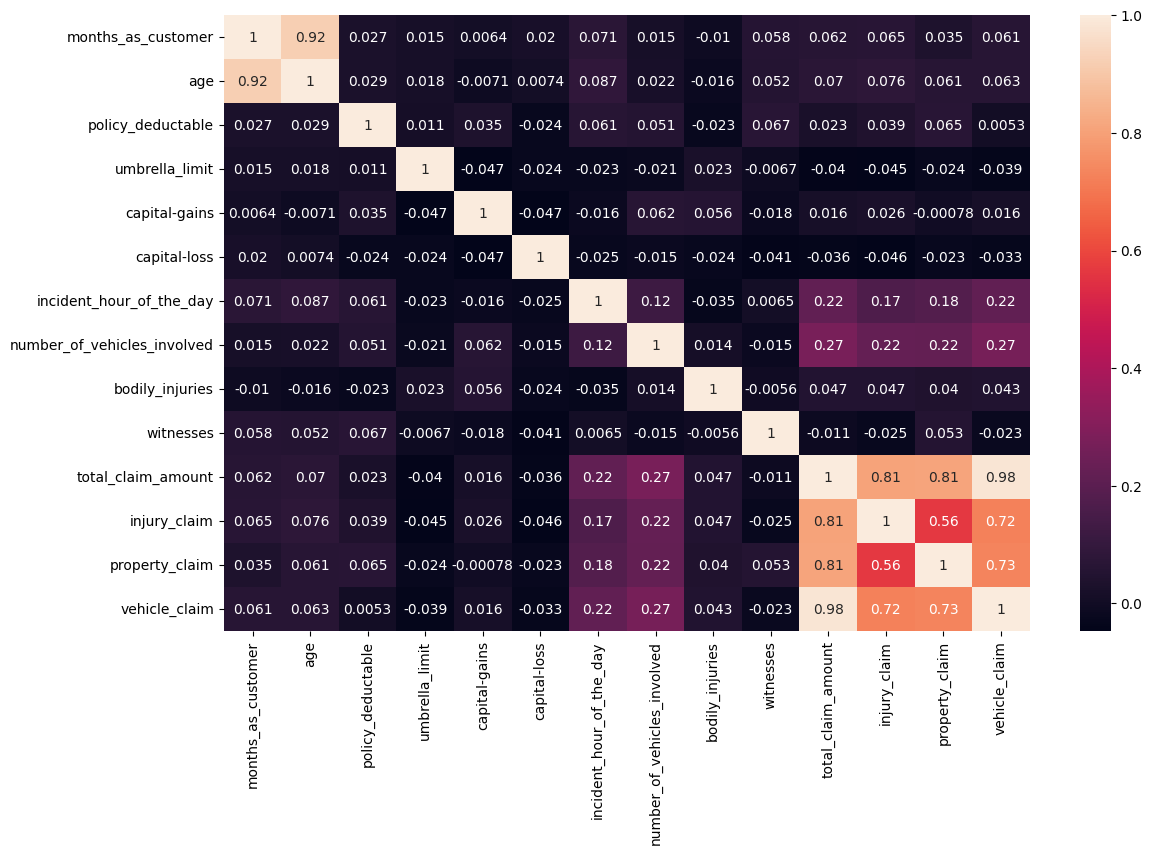

In [24]:
plt.figure(figsize=(13,8))
sns.heatmap(num_df.corr(), annot=True )

Feature Engineering: Dropping correlated columns

In [25]:
encoded_data.drop(columns=['age', 'total_claim_amount'], inplace=True)

Splitting the data into features (X) and target (y)

In [26]:
X = encoded_data.drop('fraud_reported', axis=1)
y = encoded_data['fraud_reported']

Standardize numerical features

In [27]:
numerical_cols = ['months_as_customer', 'policy_deductable', 'umbrella_limit', 'capital-gains', 'capital-loss',
                   'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
                   'injury_claim', 'property_claim', 'vehicle_claim']

In [28]:
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

Splitting the data into training and testing sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Model Training: Logistic Regression

In [30]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Predictions

In [31]:
y_pred_logistic = logistic_regression.predict(X_test)

Calculate accuracy for Logistic Regression

In [32]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Accuracy with Logistic Regression:", accuracy_logistic)

Accuracy with Logistic Regression: 0.7033333333333334


Create a confusion matrix for Logistic Regression

In [33]:
cm_logistic = confusion_matrix(y_test, y_pred_logistic)

Plot the confusion matrix

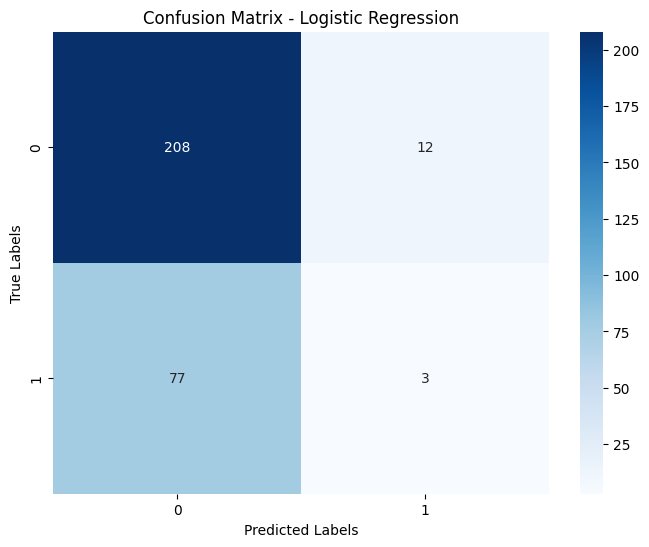

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Hyperparameter tuning for Logistic Regression using GridSearchCV

In [35]:
param_grid_logistic = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [36]:
grid_search_logistic = GridSearchCV(LogisticRegression(), param_grid_logistic, cv=5)
grid_search_logistic.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']})

Get the best parameters

In [37]:
best_params_logistic = grid_search_logistic.best_params_
print("Best Parameters for Logistic Regression:", best_params_logistic)

Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


Model Training: XGBoost Classifier (same as previous code)

In [38]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Predictions

In [39]:
y_pred_xgb = xgb_classifier.predict(X_test)

Calculate accuracy for XGBoost

In [40]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy with XGBoost Classifier:", accuracy_xgb)

Accuracy with XGBoost Classifier: 0.7633333333333333


Create a confusion matrix for XGBoost

In [41]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

Plot the confusion matrix

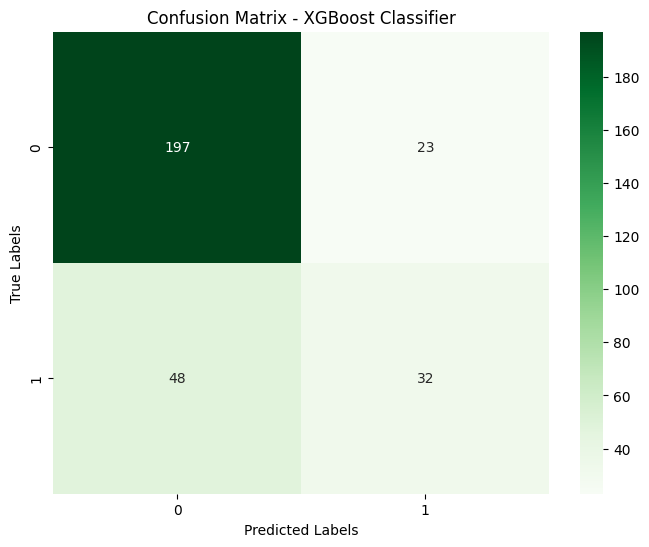

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - XGBoost Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Hyperparameter tuning for XGBoost using GridSearchCV (same as previous code)

In [43]:
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [44]:
grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]})

Get the best parameters

In [45]:
best_params_xgb = grid_search_xgb.best_params_
print("Best Parameters for XGBoost Classifier:", best_params_xgb)

Best Parameters for XGBoost Classifier: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}


Visualize Feature Importance for XGBoost Classifier (same as previous code)

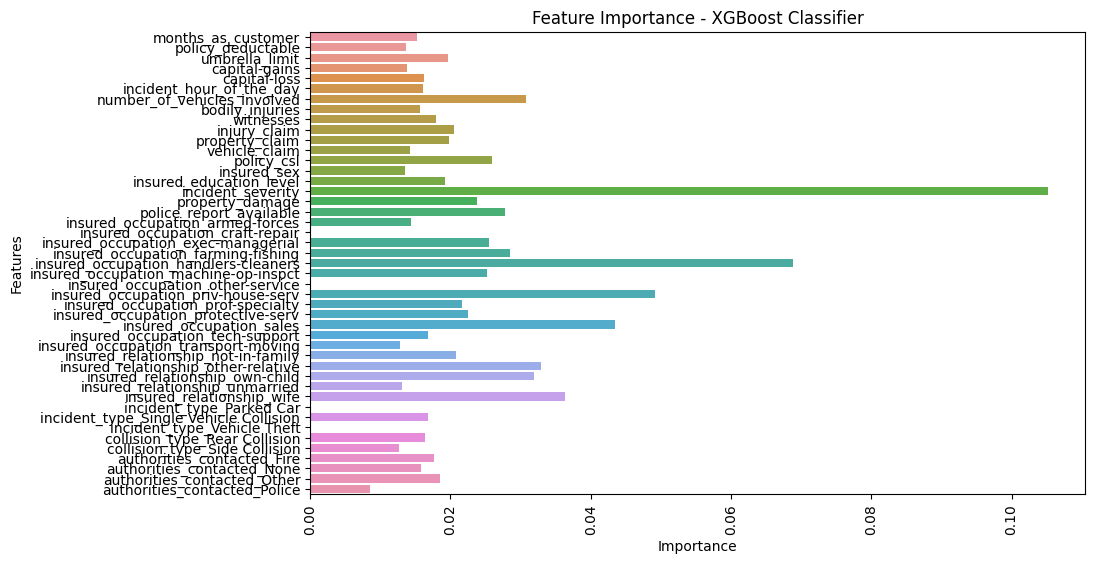

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_classifier.feature_importances_, y=X.columns)
plt.title("Feature Importance - XGBoost Classifier")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.xticks(rotation=90)
plt.show()

Model Comparison: Logistic Regression vs. XGBoost

In [47]:
print("Logistic Regression:")
print("Accuracy:", accuracy_logistic)

Logistic Regression:
Accuracy: 0.7033333333333334


Generate classification report for Logistic Regression

In [48]:
logistic_classification_report = classification_report(y_test, y_pred_logistic)
print("Classification Report for Logistic Regression:\n", logistic_classification_report)

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.73      0.95      0.82       220
           1       0.20      0.04      0.06        80

    accuracy                           0.70       300
   macro avg       0.46      0.49      0.44       300
weighted avg       0.59      0.70      0.62       300



In [49]:
print("XGBoost Classifier:")
print("Accuracy:", accuracy_xgb)

XGBoost Classifier:
Accuracy: 0.7633333333333333


Generate classification report for XGBoost

In [50]:
xgb_classification_report = classification_report(y_test, y_pred_xgb)
print("Classification Report for XGBoost:\n", xgb_classification_report)

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       220
           1       0.58      0.40      0.47        80

    accuracy                           0.76       300
   macro avg       0.69      0.65      0.66       300
weighted avg       0.74      0.76      0.75       300



Additional Analysis:<br>
- We have evaluated the models using accuracy and generated classification reports, which provide more insights into model performance.<br>
- Feature importance